<a href="https://colab.research.google.com/github/reethikanov1/it-cert-automation-practice/blob/master/Copy_of_mask_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [4]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
path='/content/drive/My Drive/lips_data'


In [6]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(path))
data = []
labels = []
print(len(imagePaths))

[INFO] loading images...
1840


load our serialized face detector model from disk

In [7]:
data = []
labels = []
c=0
# loop over the image paths
for imagePath in imagePaths:
  c=c+1
  # extract the class label from the filename
  label = imagePath.split(os.path.sep)[-2]
  print("loading ",c,"/",len(imagePaths)," label: ",label)
  # load the input image (224x224) and preprocess it
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image)
  # update the data and labels lists, respectively
  data.append(image)
  if 'out' in label:
    labels.append('nomask')
  else:
    labels.append('mask')
  #labels.append(label)

loading  1 / 1840  label:  mask (1)
loading  2 / 1840  label:  mask (1)
loading  3 / 1840  label:  mask (1)
loading  4 / 1840  label:  mask (1)
loading  5 / 1840  label:  mask (1)
loading  6 / 1840  label:  mask (1)
loading  7 / 1840  label:  mask (1)
loading  8 / 1840  label:  mask (1)
loading  9 / 1840  label:  mask (1)
loading  10 / 1840  label:  mask (1)
loading  11 / 1840  label:  mask (1)
loading  12 / 1840  label:  mask (1)
loading  13 / 1840  label:  mask (1)
loading  14 / 1840  label:  mask (1)
loading  15 / 1840  label:  mask (1)
loading  16 / 1840  label:  mask (1)
loading  17 / 1840  label:  mask (1)
loading  18 / 1840  label:  mask (1)
loading  19 / 1840  label:  mask (1)
loading  20 / 1840  label:  mask (1)
loading  21 / 1840  label:  mask (1)
loading  22 / 1840  label:  mask (1)
loading  23 / 1840  label:  mask (1)
loading  24 / 1840  label:  mask (1)
loading  25 / 1840  label:  mask (1)
loading  26 / 1840  label:  mask (1)
loading  27 / 1840  label:  mask (1)
loading  2

In [8]:
print(len(data)," ",len(labels))
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
print(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print(labels)

1840   1840
['mask' 'mask' 'mask' ... 'mask' 'mask' 'mask']
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [9]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [10]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))



9412608/9406464 [==============================] - 0s 0us/step


In [11]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)



In [12]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [13]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [14]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
46/46 [==============================] - 15s 321ms/step - loss: 0.4017 - accuracy: 0.8179 - val_loss: 0.0857 - val_accuracy: 0.9837
Epoch 2/20
46/46 [==============================] - 14s 301ms/step - loss: 0.1214 - accuracy: 0.9565 - val_loss: 0.0609 - val_accuracy: 0.9864
Epoch 3/20
46/46 [==============================] - 14s 305ms/step - loss: 0.0861 - accuracy: 0.9681 - val_loss: 0.0513 - val_accuracy: 0.9864
Epoch 4/20
46/46 [==============================] - 14s 305ms/step - loss: 0.0644 - accuracy: 0.9783 - val_loss: 0.0464 - val_accuracy: 0.9864
Epoch 5/20
46/46 [==============================] - 14s 307ms/step - loss: 0.0528 - accuracy: 0.9830 - val_loss: 0.0411 - val_accuracy: 0.9864
Epoch 6/20
46/46 [==============================] - 14s 303ms/step - loss: 0.0456 - accuracy: 0.9830 - val_loss: 0.0413 - val_accuracy: 0.9864
Epoch 7/20
46/46 [==============================] - 14s 303ms/step - loss: 0.0422 - accuracy: 0.9844 - val_loss: 0.039

In [15]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

        mask       0.98      1.00      0.99       220
      nomask       0.99      0.97      0.98       148

    accuracy                           0.99       368
   macro avg       0.99      0.98      0.99       368
weighted avg       0.99      0.99      0.99       368



In [16]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('/content/drive/My Drive/final_test.h5')



[INFO] saving mask detector model...


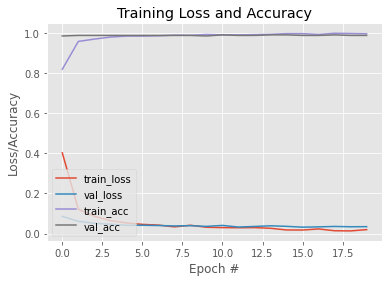

In [17]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [18]:
print("train accuracy: ",H.history["accuracy"][-1]*100)
print("train loss: ",H.history["loss"][-1]*100)
print("val accuracy: ",H.history["val_accuracy"][-1]*100)
print("val loss: ",H.history["val_loss"][-1]*100)
print("[INFO] Calculating model accuracy")
scores = model.evaluate(testX,testY)
print(f"Test Accuracy: {scores[1]*100}")

train accuracy:  99.45651888847351
train loss:  1.958918385207653
val accuracy:  98.6413061618805
val loss:  3.4357335418462753
[INFO] Calculating model accuracy
12/12 [==============================] - 0s 27ms/step - loss: 0.0344 - accuracy: 0.9864
Test Accuracy: 98.6413061618805


Testing with images from dataset

Detecting masks for multiple faces.


using face recognition module for face recognition


Using dnn for face recognition


In [41]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow 
def dnn(path):
  p=0
  nm=0
  # load our serialized model from disk
  model=load_model('/content/drive/My Drive/new_mask_img.h5')
  prototxt='/content/drive/My Drive/face_detect/deploy.prototxt'
  model1='/content/drive/My Drive/face_detect/res10_300x300_ssd_iter_140000.caffemodel'
  print("[INFO] loading model...")
  net = cv2.dnn.readNetFromCaffe(prototxt,model1)
  # load the input image and construct an input blob for the image
  # by resizing to a fixed 300x300 pixels and then normalizing it
  try:
    image = cv2.imread(path)
    image=cv2.resize(image,(300,300))
    (h, w) = image.shape[:2]
  except AttributeError:
    print("No such image...")
    return
  blob = cv2.dnn.blobFromImage(image, 1.0,(300, 300), (104.0, 177.0, 123.0))
  # pass the blob through the network and obtain the detections and
  # predictions
  sub_faces=[]
  from google.colab.patches import cv2_imshow

  print("[INFO] computing object detections...")
  net.setInput(blob)
  detections = net.forward()

  # loop over the detections
  try:
    for i in range(0, detections.shape[2]):
      # extract the confidence (i.e., probability) associated with the
      # prediction
      confidence = detections[0, 0, i, 2]
      # filter out weak detections by ensuring the `confidence` is
      # greater than the minimum confidence
      if confidence >0.5:
        p=p+1

        # compute the (x, y)-coordinates of the bounding box for the
        # object
        #print("confidence: ",confidence)
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        # draw the bounding box of the face along with the associated
        # probability
        text = "{:.2f}%".format(confidence * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        #cv2.rectangle(image, (startX, startY), (endX, endY),(0, 0, 255), 2)
        sub_faces.append(image[startY:endY,startX:endX])
        #cv2_imshow(sub_faces[-1])
        img=image[(startY+endY)//2:endY,startX:endX]
        #cv2_imshow(img)
        img = cv2.resize(img, (224, 224)).astype(np.float32) / 255
        #cv2_imshow(i)
        img = np.expand_dims(img, axis=0)
        #print(img.shape)
        prediction = model.predict(img)
        #print(prediction)
        #cv2_imshow(sub_faces[-1])
        #print(box)
        if prediction[0][0]>prediction[0][1]:
          label="Mask"
          #cv2.putText(image,str(label), (face[1]-face[2]//2,face[0]),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,1,1),1)
          cv2.rectangle(image, (startX, startY), (endX, endY), (0,255,0),2)
          cv2.putText(image, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,255,0),1)
        else:
          label="No Mask"
          nm=nm+1
          cv2.rectangle(image, (startX, startY), (endX, endY), (0,0,255),2)
          cv2.putText(image, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,0,255),1)
          #cv2.putText(image, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    print("No of people detected: ",p)
    print("No of people without mask: ",nm)
    from google.colab.patches import cv2_imshow
    image=cv2.resize(image,(500,500))
    cv2_imshow(image)
  except:
    print("No faces detected")





[INFO] loading model...
[INFO] computing object detections...
No of people detected:  7
No of people without mask:  7


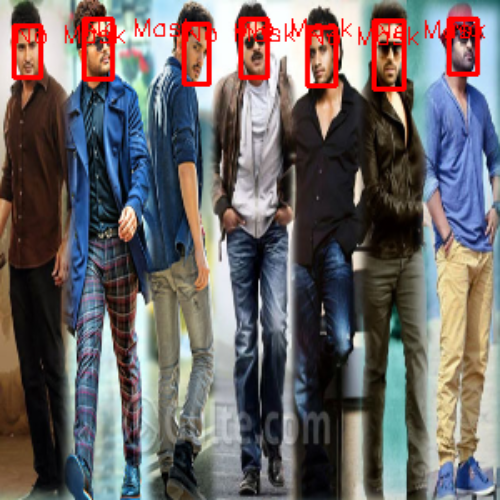

In [42]:
# import the necessary packages

dnn('/content/drive/My Drive/heros.jpg')

[INFO] loading model...
[INFO] computing object detections...
No of people detected:  11
No of people without mask:  7


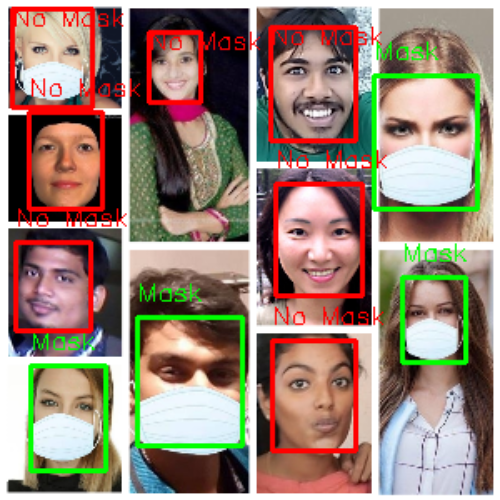

In [43]:
dnn('/content/drive/My Drive/test3.jpg')

[INFO] loading model...
[INFO] computing object detections...
No of people detected:  1
No of people without mask:  1


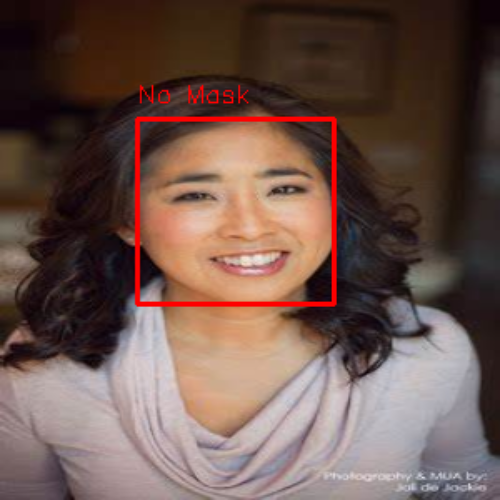

In [44]:

dnn('/content/drive/My Drive/mtest2.jpg')

[INFO] loading model...
[INFO] computing object detections...
No of people detected:  1
No of people without mask:  0


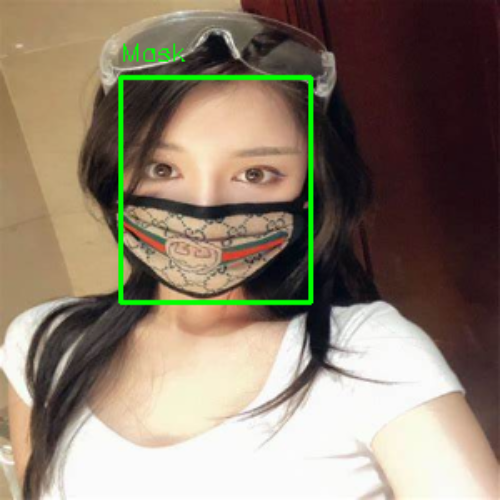

In [45]:
dnn('/content/drive/My Drive/mtest6.jpg')

[INFO] loading model...
[INFO] computing object detections...
No of people detected:  1
No of people without mask:  1


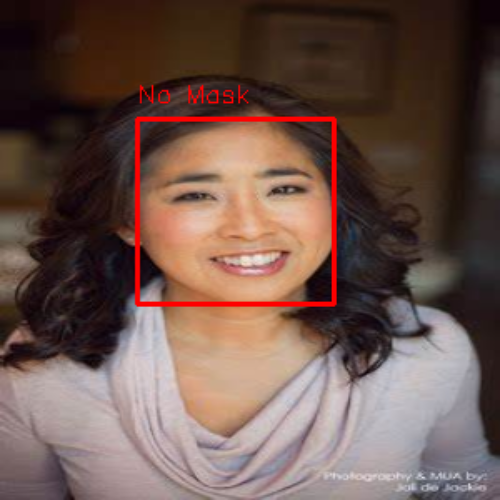

In [46]:
dnn('/content/drive/My Drive/mtest2.jpg')

[INFO] loading model...
[INFO] computing object detections...
No of people detected:  8
No of people without mask:  3


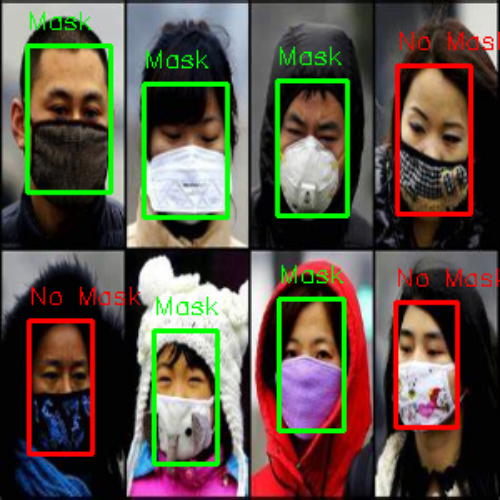

In [47]:
dnn('/content/drive/My Drive/lipstest/test1.jpg')